In [1]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from GRF_perturbations.Modules.Data_generation import Observation_conditions_class
from GRF_perturbations.Modules.Image_processing import scipy_fit_image
from GRF_perturbations.Modules.Jax_Utils import purify_function,jax_map
from GRF_perturbations.Modules.Inference import Inference_class,infer_LogNorm_params,Inference_pipeline,compute_SNR_grid,plot_likelihood,get_conf_intervals,Spectra_Loss,compute_Loss_grid

#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Observation conditions

In [2]:
pixel_number=100
pixel_scale=0.08

PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure
SNR=200 #75th percentile of COSMOS gaussian noise distribution 

Observation_conditions=Observation_conditions_class(pixel_number,pixel_scale,PSF_FWHM,SNR,exposure_time)
Inference=Inference_class(Observation_conditions)

del Observation_conditions_class
del Inference_class

Precomputing Fourier phases
Precompiling source-lens loss,gradient,hessian
Precomputing loss
Precomputing loss gradient
Precomputing loss hessian
Inference class is ready


In [3]:
noise_var=Observation_conditions.noise_var
parameters=Observation_conditions.parameters
Estimated_Noise_spectral_density=(noise_var*Observation_conditions.annulus_mask).sum()/Observation_conditions.annulus_mask.sum()

# Unperturbed image

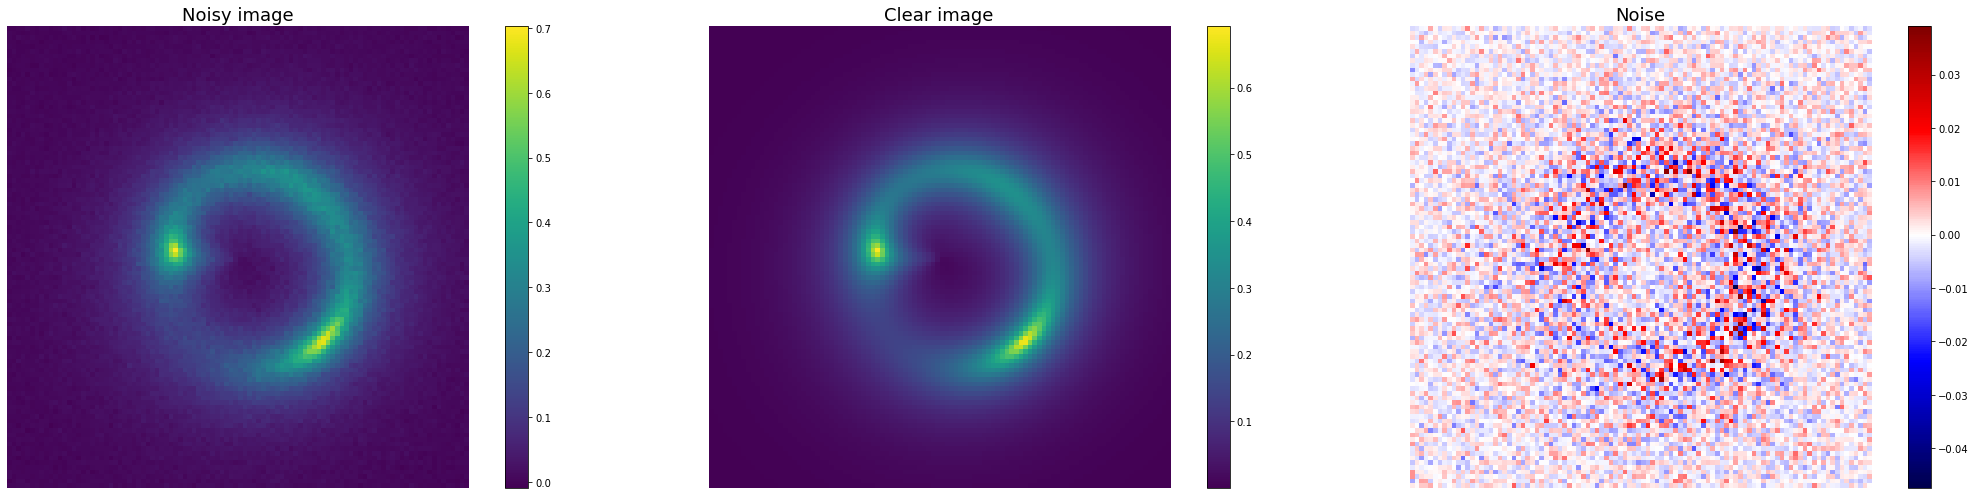

In [4]:
simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=False)
Image_unperturbed_noisy=simulate_unperturbed_image(Observation_conditions.kwargs_data,Noise_flag=True,noise_seed=42)

fig,ax=plt.subplots(1,3,figsize=(30,7))

img_arr=[]

img_arr+=[ax[0].imshow(Image_unperturbed_noisy)]
img_arr+=[ax[1].imshow(Image_unperturbed_noiseless)]
img_arr+=[ax[2].imshow(Image_unperturbed_noisy-Image_unperturbed_noiseless,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]

titles=['Noisy image','Clear image','Noise']

for i,axis in enumerate(ax):
    axis.set_title(titles[i],fontsize=FS)
    axis.axis('off')
    fig.colorbar(img_arr[i],ax=axis)

plt.tight_layout()
plt.show()

In [5]:
get_GRF=Inference.GRF_getters(True)

In [25]:
xgrid,ygrid=Observation_conditions.pixel_grid.pixel_coordinates
GRF_potential=get_GRF([-7.,2.],0)
alphax,alphay=Observation_conditions.LensImage_perturbed_noiseless.LensModel.alpha(xgrid,ygrid,[{},{},{'pixels': GRF_potential}],k=2)

In [30]:
k_vector=np.fft.fftfreq(100,0.08)

In [13]:
alphax.mean()

DeviceArray(-0.00020114, dtype=float64)

In [15]:
alphay.mean()

DeviceArray(0.00025259, dtype=float64)

In [18]:
((alphax-alphax.mean())*((alphay-alphay.mean()))).sum()/alphax.std()/alphay.std()

DeviceArray(-6.24074802, dtype=float64)

In [21]:
from GRF_perturbations.Modules.GRF_generation import nonsingular_Power_spectrum,get_k_grid

In [23]:
k_grid,nonsingular_k_grid=get_k_grid(100,0.08)
zero_mean_mask=np.ones_like(nonsingular_k_grid)
zero_mean_mask[0,0]=0
PS=nonsingular_Power_spectrum([-7,2],nonsingular_k_grid)*zero_mean_mask

In [44]:
kx,ky=np.meshgrid(k_vector,k_vector)

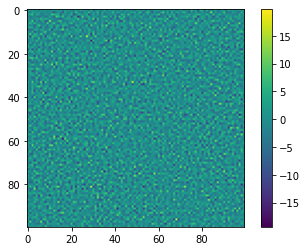

In [73]:
plt.imshow(Observation_conditions.LensImage_perturbed_noiseless.LensModel.kappa(xgrid,ygrid,[{},{},{'pixels': GRF_potential}],k=2))
plt.colorbar()

In [64]:
q.var()

0.004856794673557938

In [75]:
(PS*kx*ky).sum(axis=0)

DeviceArray([ 0.00000000e+00, -1.99920032e-09, -3.99361022e-09,
             -5.97847748e-09, -7.94912560e-09, -9.90099010e-09,
             -1.18296530e-08, -1.37308749e-08, -1.56006240e-08,
             -1.74351027e-08, -1.92307692e-08, -2.09843571e-08,
             -2.26928896e-08, -2.43536905e-08, -2.59643917e-08,
             -2.75229358e-08, -2.90275762e-08, -3.04768734e-08,
             -3.18696884e-08, -3.32051730e-08, -3.44827586e-08,
             -3.57021421e-08, -3.68632708e-08, -3.79663255e-08,
             -3.90117035e-08, -4.00000000e-08, -4.09319899e-08,
             -4.18086095e-08, -4.26309379e-08, -4.34001796e-08,
             -4.41176471e-08, -4.47847443e-08, -4.54029512e-08,
             -4.59738089e-08, -4.64989059e-08, -4.69798658e-08,
             -4.74183351e-08, -4.78159731e-08, -4.81744422e-08,
             -4.84953992e-08, -4.87804878e-08, -4.90313322e-08,
             -4.92495310e-08, -4.94366521e-08, -4.95942290e-08,
             -4.97237569e-08, -4.9826689

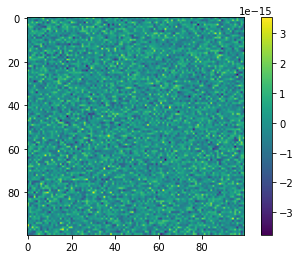

In [72]:
q=4*np.pi**2*nonsingular_k_grid.size*np.fft.fftshift(np.fft.ifft2(np.sqrt(PS)*k_grid**2*Inference.Fourier_phase_tensor[0])).imag
plt.imshow(q)
plt.colorbar()

In [71]:
(4*np.pi*PS*ky**2).sum()

DeviceArray(0.00628256, dtype=float64)

In [70]:
alphay.var()

DeviceArray(0.00594282, dtype=float64)

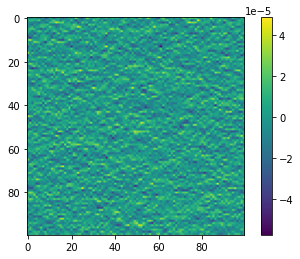

In [9]:
Observation_conditions.LensImage_perturbed_noiseless.LensModel.alpha??

# GRF Spectra grid

In [5]:
grid_size=128
logA_array=np.linspace(-9.7,-6.87,grid_size)
Beta_array=np.linspace(0,4.7,grid_size)
GRF_seeds_number=100

In [6]:
Spectra_grid=np.load('../Processing_scripts/results/Spectra_grid_node_0.npz')['arr_0']
for i in range(1,4):
    Spectra_grid=np.append(Spectra_grid,np.load('../Processing_scripts/results/Spectra_grid_node_{}.npz'.format(i))['arr_0'],axis=0)

In [8]:
SNR_grid=compute_SNR_grid(Spectra_grid,Estimated_Noise_spectral_density)

/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/Inference.py:204: RuntimeWarning: invalid value encountered in log10
  SNR=10*np.log10(np.mean(Spectra_grid-Noise_spectral_density,axis=-1)/Noise_spectral_density)


In [9]:

y_labels=np.round(logA_array,2)
x_labels=np.round(Beta_array,2)

num_ticks = 8
# the index of the position of yticks
ticks = np.linspace(0, len(logA_array) - 1, num_ticks, dtype=int)
# the content of labels of these yticks
xticklabels = np.round([x_labels[idx] for idx in ticks],2)
yticklabels = np.round([y_labels[idx] for idx in ticks],2)

def set_labels(im):
    im.set_yticks(ticks)
    im.set_yticklabels(yticklabels)
    im.set_xticks(ticks)
    im.set_xticklabels(xticklabels)

def set_labels_plt(fontsize):
    plt.gca().set_yticklabels(yticklabels,fontsize=fontsize)
    plt.gca().set_xticklabels(xticklabels,fontsize=fontsize)
    
def plot_line(ax_row,data_image,residuals_image,GRF_potential,likelihood,Confidence_grid,SNR,\
              true_logA_index,true_Beta_index,pred_logA_index,pred_Beta_index,ylabel,\
              logA_ind_lim=(0,160),Beta_ind_lim=(0,214),legend_flag=True,titles_flag=True):
    #Data
    im=ax_row[0].imshow(data_image,origin='lower')
    cbar=fig.colorbar(im,ax=ax_row[0],ticks=[0,0.2,0.4,0.6,math.floor(data_image.max()*100)/100],fraction=0.045)
    cbar.ax.set_ylabel('Flux',rotation=90,fontsize=12,labelpad=0)
    
    #Potential
    im=ax_row[1].imshow(GRF_potential,cmap='Spectral',norm=mpl.colors.TwoSlopeNorm(0),origin='lower')
    cbar=fig.colorbar(im,ax=ax_row[1],ticks=[math.ceil(GRF_potential.min()*1e+2)/1e+2,0,math.floor(GRF_potential.max()*1e+2)/1e+2],fraction=0.045)
    cbar.ax.set_ylabel(r'$\delta \psi$',rotation=90,fontsize=12,labelpad=0)
    
    #masked_resid=resids_images[i]*mask
    #norm_masked_resid=(resids_images[i]/np.sqrt(noise_vars[i]))*mask
    
    #Residuals
    normalised_masked_residuals=(residuals_image*Observation_conditions.annulus_mask)/np.sqrt(noise_var)
    colorborders=[math.ceil(normalised_masked_residuals.min()*1e+1)/1e+1,0,math.floor(normalised_masked_residuals.max()*1e+1)/1e+1]
    
    im=ax[i,2].imshow(normalised_masked_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0),origin='lower')
    cbar=fig.colorbar(im,ax=ax_row[2],ticks=colorborders,fraction=0.045)
    cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=12,labelpad=0)
    cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'])
    #fig.colorbar(im,ax=ax[i,2],ticks=[math.ceil(resids_images[i].min()*1e+3)/1e+3,0,math.floor(resids_images[i].max()*1e+3)/1e+3],fraction=0.045)
    
    
    Crop_Beta_arr=Beta_array[Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_logA_arr=logA_array[logA_ind_lim[0]:logA_ind_lim[1]]
    Crop_likelihood=likelihood[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_confidence=Confidence_grid[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    Crop_SNR=SNR[logA_ind_lim[0]:logA_ind_lim[1],Beta_ind_lim[0]:Beta_ind_lim[1]]
    
    
    Like_xticks=np.arange(10)
    Like_xticks=Like_xticks[np.where( (Like_xticks>=Crop_Beta_arr[0]) & (Like_xticks<=Crop_Beta_arr[-1]) )[0]]
    Like_yticks=np.arange(0,8)*0.5-9.5
    Like_yticks=Like_yticks[np.where( (Like_yticks>=Crop_logA_arr[0]) & (Like_yticks<=Crop_logA_arr[-1]) )[0]]
    
    
    plot_likelihood(ax_row[3],Crop_Beta_arr,Crop_logA_arr,Crop_confidence,Crop_SNR,true_logA_index-logA_ind_lim[0],true_Beta_index-Beta_ind_lim[0],\
                    pred_logA_index-logA_ind_lim[0],pred_Beta_index-Beta_ind_lim[0],Like_xticks,Like_yticks,legend_flag)
    
    ra_at_xy_0,dec_at_xy_0=Observation_conditions.pixel_grid.radec_at_xy_0
    
    for j in range(3):
        ax_row[j].set_xticks([0,50,100-1])
        ax_row[j].set_xticklabels([ra_at_xy_0,0,-ra_at_xy_0])
        ax_row[j].set_xlabel('arcsec')
        
        if j!=0:
            ax_row[j].set_yticks([0,50,100-1])
            ax_row[j].set_yticklabels([dec_at_xy_0,0,-dec_at_xy_0])
            ax_row[j].set_ylabel('arcsec',labelpad=-15)
        else:
            ax_row[j].set_yticks([])
            ax_row[j].set_ylabel('arcsec',labelpad=20)
        
    if titles_flag:
        titles=['Imaging data','Potential perturbations','Normalised residuals','Perturbations confidence']
        for j in range(4):
            ax_row[j].set_title(titles[j],fontsize=FS)
        
        
    box=ax_row[3].get_position()
    box.x0 = box.x0 + 0.02 
    ax_row[3].set_position(box)
    
    sup_ax=ax_row[0].twiny().twinx()
    sup_ax.yaxis.set_label_position('left')
    sup_ax.set_xticks([])
    
    sup_ax.yaxis.tick_left()
    #sup_ax.set_yticks([])
    sup_ax.set_yticks([0,50,100-1])
    sup_ax.set_yticklabels([dec_at_xy_0,0,-dec_at_xy_0])
    #sup_ax.set_ylabel('arcsec',labelpad=-15)
    
    
    sup_ax.set_ylabel(ylabel,fontsize=FS,rotation=0)
    #sup_ax.set_ylabel(r"${\rm log}(A)$",fontsize=FS,rotation=0)
    sup_ax.yaxis.set_label_coords(-0.3,0.38)

# Inference test

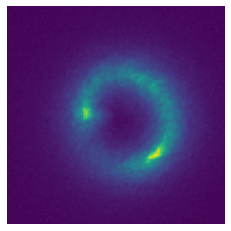

In [10]:
GRF_params=[-7.5,2.]
GRF_seed_index=4

get_GRF=Inference.GRF_getters(True)
GRF_potential=get_GRF(GRF_params,GRF_seed_index)

noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(GRF_seed_index+1)*1e+5)).astype(int)

simulate_perturbed_image=Observation_conditions.perturbed_image_getter
simulated_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,True,noise_seed)

plt.imshow(simulated_image)
plt.axis('off')
plt.show()

In [11]:
args_fit=Inference.differentiable_fit_image(simulated_image)

simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
fit_image=simulate_unperturbed_image(Observation_conditions.parameters.args2kwargs(args_fit),Noise_flag=False)

residuals=simulated_image-fit_image
spectrum=Inference.compute_radial_spectrum(residuals)

In [12]:
true_logA_index=np.argmin(np.abs(logA_array-GRF_params[0]))
true_Beta_index=np.argmin(np.abs(Beta_array-GRF_params[1]))

likelihood,Confidence_grid,pred_logA_index,pred_Beta_index=Inference_pipeline(spectrum,Spectra_grid,true_logA_index,true_Beta_index)

Uncertainties estimation took 0.3 seconds
Loss grid computation took 0.3 seconds
Confidence grid computation took 0.0 seconds


/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/Inference.py:218: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  contours+=[np.array(measure.find_contours(likelihood,isolevel))]


Text(0.4, 1.0, 'Likelihood')

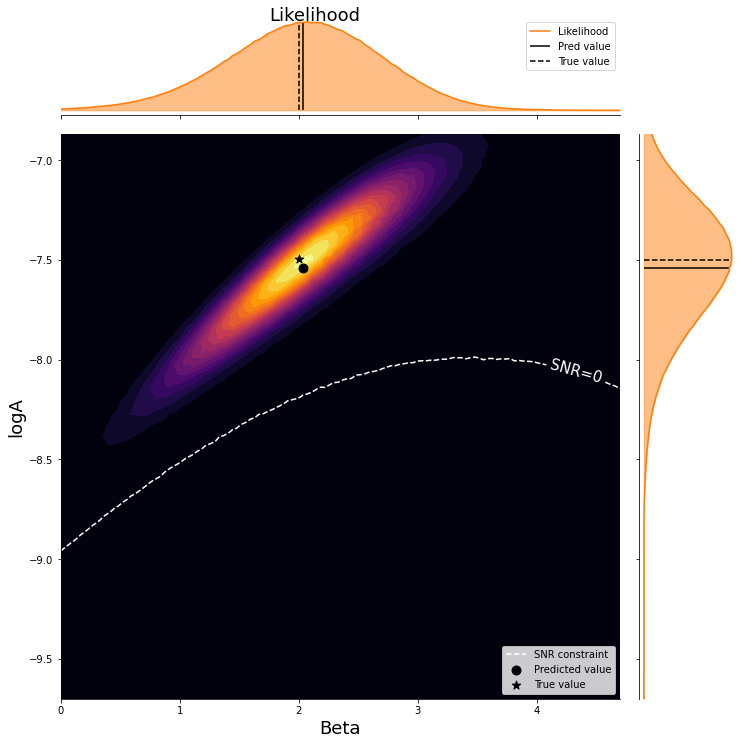

In [76]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage as ndimage

g = sns.JointGrid(height=10)
#levels=np.linspace(0,likelihood.max(),21)

levels=np.linspace(0,(likelihood.max()*10).round()/10,21)
ct=g.ax_joint.contourf(Beta_array,logA_array,likelihood,levels, cmap='inferno')
#ct.collections[0].set_label('Likelihood')

#SNR constraint

img=g.ax_joint.contour(Beta_array,logA_array,SNR_grid,[0],colors='w',linestyles='--')
img.collections[0].set_label('SNR constraint')

fmt = {}
strs = ['SNR=0']
for l,s in zip( img.levels, strs ):
    fmt[l] = s

manual_locations=[(10,4)]
g.ax_joint.clabel(img,[0],inline=1,fontsize=15,fmt=fmt,manual=manual_locations)

#Prediction and truth


g.ax_joint.scatter(Beta_array[pred_Beta_index],logA_array[pred_logA_index],label='Predicted value',marker="o",s=80,color='k')
g.ax_joint.scatter(Beta_array[true_Beta_index],logA_array[true_logA_index],label='True value',marker="*",s=80,color='k')


#Marginalized Beta likelihood

Beta_likelihood=likelihood.mean(axis=0)

likelihood_color='C1'
g.ax_marg_x.plot(Beta_array,Beta_likelihood,color=likelihood_color,label='Likelihood')
g.ax_marg_x.fill_between(Beta_array,0,Beta_likelihood,alpha=0.5,color=likelihood_color)


g.ax_marg_x.vlines(Beta_array[pred_Beta_index],0,Beta_likelihood[pred_Beta_index],color='black',label='Pred value')
g.ax_marg_x.vlines(GRF_params[1],0,likelihood.mean(axis=0)[true_Beta_index],color='k',label='True value',linestyle='--')



g.ax_marg_x.legend(loc='upper right')

#Marginalized logA likelihood
logA_likelihood=likelihood.mean(axis=1)

g.ax_marg_y.plot(logA_likelihood,logA_array,color=likelihood_color,label='Likelihood')
g.ax_marg_y.fill_betweenx(logA_array,0,logA_likelihood,alpha=0.5,color=likelihood_color)

g.ax_marg_y.hlines(logA_array[pred_logA_index],0,logA_likelihood[pred_logA_index],color='black',label='Pred value')
g.ax_marg_y.hlines(GRF_params[0],0,logA_likelihood[true_logA_index],color='k',label='True value',linestyle='--')


g.ax_joint.set_xlabel('Beta',fontsize=FS)
#g.ax_joint.set_xlim(xlim[0],xlim[1])
g.ax_joint.set_ylabel('logA',fontsize=FS)
#g.ax_joint.set_ylim(ylim[0],ylim[1])

g.ax_joint.legend(loc='lower right')
#g.fig.suptitle('Loss='+r'$(\frac{data-model}{\sqrt{\sigma^2_{\sigma^2_{noise}}+\sigma^2_{binning}+\sigma^2_{phase}}})^2$',fontsize=FS,y=1.1)
g.fig.suptitle('Likelihood',fontsize=FS,y=1.,x=0.4)

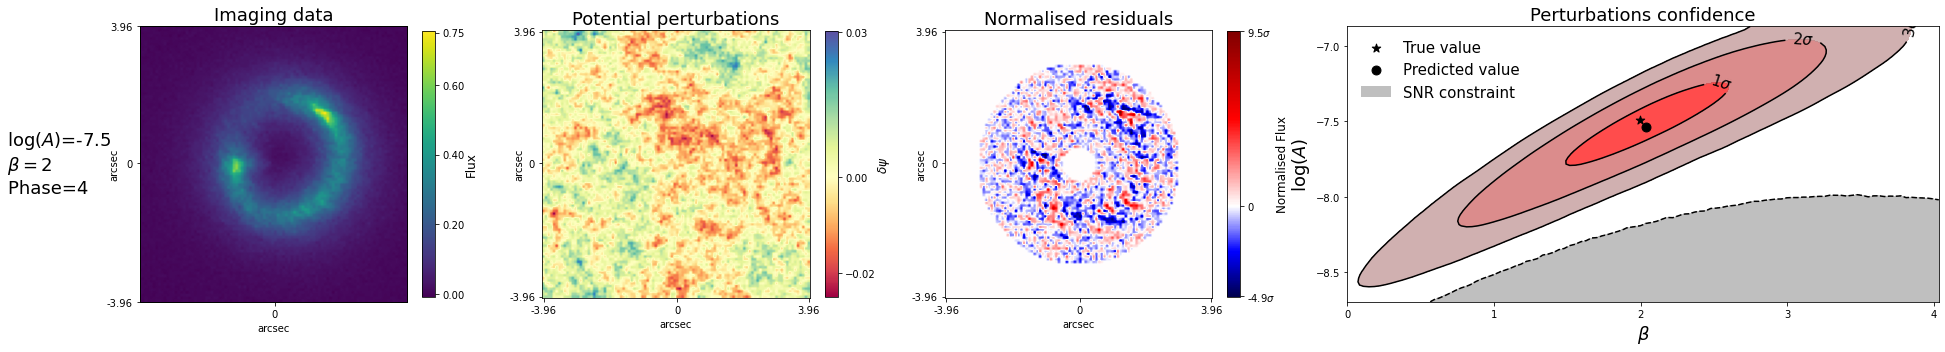

In [77]:
from matplotlib import gridspec
fig=plt.figure(figsize=(27,5))
gs = gridspec.GridSpec(1, 4,
                       width_ratios=[1,1,1,2],
                       height_ratios=[1])
ax=[]
for i in range(1):
    ax_row=[]
    for j in range(4):
        axis=plt.subplot(gs[4*i+j])
        ax_row+=[axis]
    ax+=[ax_row]
    
ax=np.array(ax)

ylabel=r"${\rm log}(A)$"+"={:.1f}".format(GRF_params[0])+'\n'+r'$\beta=$'+'{:.0f}           \n'.format(GRF_params[1])+'Phase={:.0f}    '.format(GRF_seed_index)

plot_line(ax[0],simulated_image,residuals,GRF_potential,likelihood,Confidence_grid,SNR_grid,\
          true_logA_index,true_Beta_index,pred_logA_index,pred_Beta_index,ylabel,\
          logA_ind_lim=(45,128),Beta_ind_lim=(0,110),legend_flag=True)

plt.tight_layout(h_pad=3,w_pad=2)

In [81]:
pred_logA_index,pred_Beta_index,logA_conf_regions,Beta_conf_regions=get_conf_intervals(likelihood)

In [91]:
print('True logA={:.2f}'.format(GRF_params[0])+' Predicted logA={:.2f}'.format(logA_array[pred_logA_index]))
print('Confidence {:.2f} +{:.2f}'.format(*(logA_array[logA_conf_regions[0]]-logA_array[pred_logA_index])))

print('\nTrue Beta={:.2f}'.format(GRF_params[1])+' Predicted Beta={:.2f}'.format(Beta_array[pred_Beta_index]))
print('Confidence {:.2f} +{:.2f}'.format(*(Beta_array[Beta_conf_regions[0]]-Beta_array[pred_Beta_index])))

True logA=-7.50 Predicted logA=-7.54
Confidence -0.33 +0.27

True Beta=2.00 Predicted Beta=2.04
Confidence -0.63 +0.59


In [89]:
def get_cdf(likelihood):
    cdf=jnp.cumsum(likelihood)
    normalised_cdf=cdf/cdf[-1]

    return normalised_cdf

def get_prediction(cdf,pred_index,precentage_covered):
    #indent=np.minimum(0.5,percentage_covered/200.)
    indent=precentage_covered/200.

    upper_index=jnp.argmin(jnp.abs(cdf-cdf[pred_index]-indent))
    lower_index=jnp.argmin(jnp.abs(cdf-cdf[pred_index]+indent))

    return jnp.array([lower_index,upper_index])

def get_conf_intervals(likelihood):

    Beta_cdf=get_cdf(likelihood.mean(axis=0))
    Beta_pred_index=jnp.argmin(jnp.abs(Beta_cdf-0.5))


    logA_cdf=get_cdf(likelihood.mean(axis=1))
    logA_pred_index=jnp.argmin(jnp.abs(logA_cdf-0.5))

    percentage_covered=jnp.array([68,95,99.7])
    Beta_conf_regions=np.zeros((3,2))
    logA_conf_regions=np.zeros((3,2))

    
    Beta_conf_regions=jax_map(lambda percentage: get_prediction(Beta_cdf,Beta_pred_index,percentage),percentage_covered)
    logA_conf_regions=jax_map(lambda percentage: get_prediction(logA_cdf,logA_pred_index,percentage),percentage_covered)

    
    res_matrix=jnp.array([[logA_pred_index,Beta_pred_index]])
    res_matrix=jnp.append(res_matrix,logA_conf_regions,axis=0)
    res_matrix=jnp.append(res_matrix,Beta_conf_regions,axis=0)
    
    return res_matrix

def get_likelihood(data_spectrum,Spectra_grid,true_logA_index,true_Beta_index):
    
    logdata_spectrum=jnp.log(data_spectrum)
    gamma_data,mu_data,sigma_data=infer_LogNorm_params(Spectra_grid[true_logA_index,true_Beta_index])
    
    Spectra_Loss_pure=lambda model_spectra: Spectra_Loss(model_spectra,logdata_spectrum,sigma_data)
    i
    Loss_grid=compute_Loss_grid(Spectra_grid,Spectra_Loss_pure)
    likelihood=jnp.exp(-Loss_grid/2)
    
    return likelihood

In [96]:
def compute_predictions_seeds(true_logA_index,true_Beta_index,Spectra_grid):
    
    data_spectra=Spectra_grid[true_logA_index,true_Beta_index]
    
    likelihoods=jax_map(lambda data_spectrum: get_likelihood(data_spectrum,Spectra_grid,true_logA_index,true_Beta_index),data_spectra)
    
    res=jax_map(get_conf_intervals,likelihoods)
    
    return res 

In [97]:
start_time=time.time()
res=func(90,50,Spectra_grid)
print(time.time()-start_time)

9.003613233566284


In [95]:
res.shape

(10, 7, 2)

In [91]:
get_conf_intervals(likelihood)

DeviceArray([[ 97,  55],
             [ 82, 110],
             [ 61, 119],
             [  0, 123],
             [ 37,  72],
             [ 19,  88],
             [  4, 111]], dtype=int64)

In [79]:
jnp.array([jnp.array([res[0]]),res[1],res[2]])

ValueError: All input arrays must have the same shape.

In [85]:
jnp.array([res[0]]).shape

(1, 2)

In [84]:
res[1].shape

(3, 2)

In [88]:
jnp.append(jnp.array([res[0]]),res[1],axis=0)

DeviceArray([[ 97,  55],
             [ 82, 110],
             [ 61, 119],
             [  0, 123]], dtype=int64)

In [99]:
np.arange(10,128)

array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127])

In [101]:
logA_array=np.linspace(-9.7,-6.87,128)

In [102]:
logA_indices_to_process=np.arange(0*1,(0+1)*1)

In [103]:
logA_indices_to_process

array([0])

In [107]:
for i in range(len(logA_indices_to_process)):
        print('echo i={:.0f} logA_index={:.0f} logA={:.2f}'.format(i,logA_indices_to_process[i],logA_array[logA_indices_to_process[i]]))

echo i=0 logA_index=0 logA=-9.70


In [106]:
logA_indices_to_process[i]

0

In [111]:
def compute_predictions_seeds(true_logA_index,true_Beta_index,Spectra_grid):

    data_spectra=Spectra_grid[true_logA_index,true_Beta_index]

    likelihoods=jax_map(lambda data_spectrum: get_likelihood(data_spectrum,Spectra_grid,true_logA_index,true_Beta_index),data_spectra)

    res=jax_map(get_conf_intervals,likelihoods)

    return res

Beta_indices=np.arange(0,1)

compute_Predictions_Betas= jax.jit(lambda logA_index: jax_map(lambda Beta_index: compute_predictions_seeds(logA_index,Beta_index,jnp.array(Spectra_grid)),Beta_indices))

In [112]:
res=compute_Predictions_Betas(0)

In [113]:
res.shape

(1, 100, 7, 2)

In [2]:
import numpy as np
import os

In [3]:
q=np.zeros((100,100,100))

In [4]:
os.system('echo {}'.format(q.shape))

sh: -c: line 0: syntax error near unexpected token `100,'
sh: -c: line 0: `echo (100, 100, 100)'


512